In [1]:
# Cell 1: Imports and Raw DP Data Loading

import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
import matplotlib.pyplot as plt
import os # <-- Ensure os is imported

# ⭐️ REPLACE the environment variables setup in Cell 1 ⭐️

# ==========================================
# ⚡ GPU Initialization and Setup 
# ==========================================
import tensorflow as tf

# Suppress warnings and info messages (Level 3 = Errors only)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

# Enable full GPU memory and multi-GPU graph
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ TensorFlow found and initialized {len(gpus)} GPU(s).")
else:
    print("ℹ️ No GPU detected by TensorFlow.")
# ==========================================

plt.ion()

# Load raw DP data
data = sio.loadmat('dp_results_for_plant.mat', squeeze_me=True)

# Drive cycle and control/state profiles
speed           = data['Speed'].flatten()
temp            = data['Temp'].flatten()
power_req       = data['PowerReq'].flatten()
gear            = data['Gear'].flatten().astype(int)
engine_power    = data['PowerEng'].flatten()
engine_status   = data['EngStatus'].flatten()      # 0 = OFF, 1 = ON

Ib_dp           = data['Ib'].flatten()
Pb_dp           = data['Pb'].flatten()

# Plant state variables from DP
soc     = data['SOC'].flatten()
q_sei   = data['Q_SEI'].flatten()
q_am    = data['Q_AM'].flatten()

# Degradation and fuel from DP
dq_sei          = data['dQ_SEI'].flatten()
dq_am           = data['dQ_AM'].flatten()
m_dot_fuel_dp   = data['m_dot_fuel'].flatten()
Time_s          = data['Time_s'].flatten()

# Control input (2D): [engine_power, engine_status]
dp_controls = np.vstack([engine_power, engine_status]).T  # shape (N, 2)

# Plant state (3D): [SOC, Q_SEI, Q_AM]
dp_states = np.vstack([soc, q_sei, q_am]).T

print("Loaded DP dataset:")
print("Inputs: speed, temp, power_req, gear")
print("Controls: engine_power [W], engine_status [0/1]")
print("States: SOC, Q_SEI, Q_AM")

2025-11-18 19:18:20.643142: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 19:18:21.930605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ TensorFlow found and initialized 1 GPU(s).
Loaded DP dataset:
Inputs: speed, temp, power_req, gear
Controls: engine_power [W], engine_status [0/1]
States: SOC, Q_SEI, Q_AM


In [2]:
# Cell 2: Safe mat_struct conversion + Engine Operating Point Finder

# from scipy.io.matlab.mio5_params import mat_struct
# ⭐️ REPLACE the problematic line 3 in Cell 2 with this: ⭐️
from scipy.io.matlab import mat_struct

# Recursive converter for mat_struct to dict
def mat_struct_to_dict(obj):
    if isinstance(obj, mat_struct):
        result = {}
        for field_name in obj._fieldnames:
            field_val = getattr(obj, field_name)
            result[field_name] = mat_struct_to_dict(field_val)
        return result
    elif isinstance(obj, np.ndarray):
        if obj.dtype == 'O':  # object array (likely nested structs)
            return np.array([mat_struct_to_dict(o) for o in obj])
        else:
            return obj
    else:
        return obj

# Engine operating point function
def find_best_engine_operating_point(ENG_raw, GEN_raw, P_eng_req):
    # Convert structs
    ENG = mat_struct_to_dict(ENG_raw)
    GEN = mat_struct_to_dict(GEN_raw)

    we_grid = np.array(ENG["speed_range"]).flatten()
    Te_grid = np.array(ENG["Torq_range"]).flatten()

    Tmax_engine = np.interp(we_grid, ENG["maxTrq_w"], ENG["max_torque_v"])
    Tmax_gen = np.interp(we_grid, GEN["maxTrqCrv_w"], GEN["maxTrqCrv_trq_peak"])
    Tmax_both = np.minimum(Tmax_engine, Tmax_gen)

    Pmax_map = we_grid * Tmax_both
    idx_map_max = np.argmax(Pmax_map)
    Pmap_max = Pmax_map[idx_map_max]
    we_map_max = we_grid[idx_map_max]
    Te_map_max = Tmax_both[idx_map_max]

    mf_map = np.array(ENG["mf"])
    if mf_map.shape != (len(Te_grid), len(we_grid)):
        mf_map = mf_map.T  # transpose if needed

#     mf_interp = interp2d(we_grid, Te_grid, mf_map, kind='linear', fill_value=np.inf)
    
    mf_interp = RegularGridInterpolator(
        (Te_grid, we_grid),  # Te: rows, we: columns
        mf_map,
        bounds_error=False,
        fill_value=np.inf
    )

#     mf_map_max = mf_interp(we_map_max, Te_map_max)[0]
    mf_map_max = mf_interp([[Te_map_max, we_map_max]])[0]


    best_we = 0.0
    best_Te = 0.0
    best_mf = 0.0
    best_Peng = 0.0
    best_Pgen = 0.0
    best_gen_eff = 0.0

    mf_cand = np.full_like(we_grid, np.inf, dtype=np.float64)
    Te_cand = np.full_like(we_grid, np.nan, dtype=np.float64)

    for i, w in enumerate(we_grid):
        T_req = P_eng_req / w if w > 1e-6 else 0.0
        if 0 <= T_req <= Tmax_both[i]:
#             mf_cand[i] = mf_interp(w, T_req)[0]
            mf_cand[i] = mf_interp([[T_req, w]])[0]
            Te_cand[i] = T_req

    if np.all(np.isinf(mf_cand)):
        best_we = we_map_max
        best_Te = Te_map_max
        best_mf = mf_map_max
        best_Peng = Pmap_max
    else:
        idx_best = np.argmin(mf_cand)
        best_we = we_grid[idx_best]
        best_Te = Te_cand[idx_best]
        best_mf = mf_cand[idx_best]
        best_Peng = best_we * best_Te

    eff_interp = RegularGridInterpolator(
        (GEN["effMapPos_w"], GEN["effMapPos_trq"]),
        GEN["effMapPos_eff"],
        bounds_error=False,
        fill_value=np.nan
    )
    eff = eff_interp([[best_we, best_Te]])[0]
    if np.isnan(eff) or eff <= 0 or eff > 1.5:
        best_gen_eff = 0
        best_Pgen = 0
    else:
        best_gen_eff = eff
        best_Pgen = eff * best_Peng

    return best_we, best_Te, best_mf, best_Peng, best_Pgen, best_gen_eff


In [17]:
# Cell 3: HEVSimulator with Series Hybrid Logic

class HEVSimulator:
    def __init__(self, param_file, drive_file):
        self.params = sio.loadmat(param_file, squeeze_me=True, struct_as_record=False)
        self.drive = sio.loadmat(drive_file, squeeze_me=True, struct_as_record=False)

        # Drive cycle
        self.v = self.drive['speed_vector'].flatten()
        self.a = self.drive['acceleration_vector'].flatten()
        self.grad = self.drive['elevation_vector'].flatten()
        self.N = len(self.v)

        # Parameters
        p = self.params
        self.BAT = p['BAT_LFP']
        self.ENG = p['ENG']
        self.MOT = p['MOT']
        self.TRAN = p['TRAN']
        self.ENV = p['ENV']
        self.VEH = p['VEH']
        self.GEN = p['GEN']

        self.Ts = 1.0
        
        temp_C = getattr(self.BAT, 'temp', 25.0)   # default value
        self.T_K = temp_C + 273.15
        
        
        self.R_val = 8.314
        self.i0 = 0.05
        self.lemda = -3.2895e3
        self.k_SEI = 2.0368e-05
        self.E_SEI = -8.9696
        self.k_AM = 6.8885e-08
        self.E_AM = 0.0013
        self.theta = 6.7872e-06
        self.Q_SEI_0 = (
            (self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2 /
            ((2 * (1 + self.lemda * self.theta))**2 * self.i0)
        )

        self.r = float(self.VEH.r)
        self.rho = float(self.ENV.rho)
        self.Af = float(self.VEH.Af)
        self.Cd = float(self.VEH.Cd)
        self.Cr = float(self.VEH.Cr)
        self.M = float(self.VEH.M)
        self.Mv = float(self.VEH.Mv)
        self.g = float(self.ENV.g)

        temp_list = np.array(self.BAT.temp_list).flatten()
        soc_list = np.array(self.BAT.soc_list).flatten()
        R_dis = np.array(self.BAT.battery_soc_Rdis).T
        R_chg = np.array(self.BAT.battery_soc_Rchg).T

        self.r_interp_dis = RegularGridInterpolator((temp_list, soc_list), R_dis) # <-- ADD self.
        self.r_interp_chg = RegularGridInterpolator((temp_list, soc_list), R_chg) # <-- ADD self.
        

    def evaluate_step(self, k, SOC_k, Q_SEI_k, Q_AM_k, engine_power, engine_status, gear, power_req):
        v = self.v[k]
        a = self.a[k]
        grad = self.grad[k]

        wv = v / self.r
        dwv = a / self.r
        Tv = (self.Cr * self.M * self.g * np.cos(grad)
              + 0.5 * self.rho * self.Cd * self.Af * v**2
              + self.Mv * a + self.M * self.g * np.sin(grad)) * self.r

        rg = self.TRAN.r_gear[int(gear) - 1]
        wg = rg * wv
        dwg = rg * dwv

        Tm = power_req / wg if wg > 1e-6 else 0.0
        wm_list = np.array(self.MOT.wm_list).flatten()
        Tm_list = np.array(self.MOT.Tm_list).flatten()
        Tm_max = np.interp(wg, self.MOT.max_wm_list, self.MOT.Tmmax)
        Tm_min = np.interp(wg, self.MOT.min_wm_list, self.MOT.Tmmin)
        Tm = np.clip(Tm, Tm_min, Tm_max)

        etam = np.array(self.MOT.etam)
        eff_interp = RegularGridInterpolator((wm_list, Tm_list), etam, bounds_error=False, fill_value=1.0)
        eff_m = eff_interp([[wg, abs(Tm)]])[0]

        Tm0 = 0
        P_drag_motor = wg * Tm0
        P_aux = 5000.0

        if Tm >= 0:
            Pm = (Tm * wg + P_drag_motor) / eff_m
        else:
            Pm = (Tm * wg + P_drag_motor) * eff_m

        P_idle_thresh = 6000
        mf_idle = 0.5
        we_idle = self.ENG.speed_range[0]
        if engine_status == 0 or engine_power <= 0:
            we = 0
            Te = 0
            m_dot_fuel = 0
            Pgen = 0
            Pgen_loss = 0
        elif engine_power <= P_idle_thresh:
            we = we_idle
            Te = 0
            m_dot_fuel = mf_idle
            Pgen = 0
            Pgen_loss = 0
        else:
            we, Te, m_dot_fuel, Peng_out, Pgen, gen_eff = find_best_engine_operating_point(
                self.ENG, self.GEN, engine_power
            )
            engine_power = Peng_out
            Pgen_loss = ((1. / gen_eff) - 1) * Pgen if gen_eff > 0 else 0

        if Pm >= 0:
            Pb = Pm - Pgen
        else:
            engine_power = 0
            Pgen = 0
            Pb = Pm
        Pb += P_aux

        ########################################################
        
        Ns = float(self.BAT.Ns)
        v0 = float(self.BAT.v0)
        alpha0 = float(self.BAT.alpha0)
        beta = float(self.BAT.beta)
        gamma_b = float(self.BAT.gamma)
        zeta_b = float(self.BAT.zeta)
        epsilon = float(self.BAT.epsilon)
        v = Ns * (v0 + alpha0 * (1 - np.exp(-beta * SOC_k))
                     + gamma_b * SOC_k
                     + zeta_b * (1 - np.exp(-epsilon / (1 - SOC_k))))

        # temp_list = np.array(self.BAT.temp_list).flatten()
        # soc_list = np.array(self.BAT.soc_list).flatten()
        # R_dis = np.array(self.BAT.battery_soc_Rdis).T
        # R_chg = np.array(self.BAT.battery_soc_Rchg).T
        # r_interp_dis = RegularGridInterpolator((temp_list, soc_list), R_dis)
        # r_interp_chg = RegularGridInterpolator((temp_list, soc_list), R_chg)
        r_bat = self.r_interp_dis([[25.0, SOC_k]])[0] if Pb >= 0 else self.r_interp_chg([[25.0, SOC_k]])[0]

        e = 1.0 if Pb >= 0 else 0.9
        discriminant = v**2 - 4 * r_bat * Pb
#         discriminant = max(discriminant, 0)
        Ib = e * (v - np.sqrt(discriminant)) / (2 * r_bat)
        Ib = np.clip(Ib, -self.BAT.Ib_max, self.BAT.Ib_max)

        Cap_Ah = float(self.BAT.Bat_cap) * float(self.BAT.Np)
        SOC_next = SOC_k - Ib / (Cap_Ah * 3600) * self.Ts

        Ib_cell = Ib / float(self.BAT.Np)
        ########################################################

        # # ⭐️ REPLACE the Voltage/Resistance/Current calculation block in evaluate_step (Cell 3) ⭐️
        
        # Ns = float(self.BAT.Ns)
        # Np = float(self.BAT.Np) # Use Np for parallel scaling

        # # --- 1. Calculate Single-Cell Open Circuit Voltage (v_cell) ---
        # v0 = float(self.BAT.v0)
        # alpha0 = float(self.BAT.alpha0)
        # beta = float(self.BAT.beta)
        # gamma_b = float(self.BAT.gamma)
        # zeta_b = float(self.BAT.zeta)
        # epsilon = float(self.BAT.epsilon)
        
        # # OCV for a single cell
        # v_cell = (v0 + alpha0 * (1 - np.exp(-beta * SOC_k))
        #                   + gamma_b * SOC_k
        #                   + zeta_b * (1 - np.exp(-epsilon / (1 - SOC_k))))
        
        # # Pack voltage v (used in the original equation)
        # v = Ns * v_cell
        
        # # --- 2. Calculate Cell Resistance and Pack Resistance ---
        # # R_cell: Resistance of one cell (from interpolators)
        # R_cell = self.r_interp_dis([[25.0, SOC_k]])[0] if Pb >= 0 else self.r_interp_chg([[25.0, SOC_k]])[0]
        
        # # Pack Resistance (R_pack) based on Ns/Np scaling
        # r_bat = R_cell * Ns / Np 
        
        # # --- 3. Solve for Pack Current (Ib) ---
        # e = 1.0 if Pb >= 0 else 0.9
        
        # # 🛑 CRITICAL FIX for Aging: Use the single cell basis to derive the *Cell Current*.
        # # We solve the quadratic for the single cell (V_cell, R_cell, P_b_cell) 
        # # and then scale back to Ib_pack for the physics balance.
        
        # # Calculate Power per Cell (P_b_cell): Total Pack Power / Total Cells
        # # This isolates the current solution from implicit Ns scaling.
        # P_b_cell = Pb / (Ns * Np) 
        
        # # Solve for Cell Current (Ib_cell) using the single-cell equation
        # discriminant_cell = v_cell**2 - 4 * R_cell * P_b_cell
        # discriminant_cell = np.maximum(discriminant_cell, 0.0) # Ensure stability
        
        # # Ib_cell solution
        # Ib_cell = e * (v_cell - np.sqrt(discriminant_cell)) / (2 * R_cell)
        
        # # Reconstruct Pack Current (Ib) for the SOC balance using the solved Ib_cell
        # Ib = Ib_cell * Np
        
        # # Clamp Pack Current
        # Ib = np.clip(Ib, -self.BAT.Ib_max, self.BAT.Ib_max) 

        # # --- 4. Calculate Final SOC ---
        # Cap_Ah_pack = float(self.BAT.Bat_cap) * Np
        # SOC_next = SOC_k - Ib / (Cap_Ah_pack * 3600) * self.Ts

        # # 5. Final Output Variables
        # # Ib_cell is already correctly calculated above.
        # # The remaining dQ calculations will use this pure Ib_cell.
        
        ########################################################

        
        z = SOC_next
        U_n_OCP = (0.6379 + 0.5416 * np.exp(-305.5309 * z) + 0.044 * np.tanh(-(z - 0.1958)/0.1088)
                   - 0.1978 * np.tanh((z - 1.0571)/0.0854) - 0.6875 * np.tanh((z + 0.1117)/0.0529)
                   - 0.0175 * np.tanh((z - 0.5692)/0.0875))
        U_s_OCP = 0.4
        Ib_cell_calendar = -Ib_cell  # Flip sign to match aging model convention
        zeta = (7.5e-6 * Ib_cell_calendar) / (6 * 0.552 * self.i0 * 1.26e-5)
        eta_k = (self.R_val * self.T_K) / (0.5 * 96485.3321) * np.log(zeta + np.sqrt(zeta**2 + 1))
        theta = np.exp((1 * 96485.3321) / (self.R_val * self.T_K) * (eta_k + U_n_OCP - U_s_OCP))

        # --- These next values are used internally to compute dQ values ---
        Q_SEI_next = Q_SEI_k + ((self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2 /
                                ((2 * (1 + self.lemda * theta))**2 * Q_SEI_k)) * self.Ts
        Q_AM_next = Q_AM_k + (self.k_AM * np.exp(-self.E_AM / (self.R_val * self.T_K)) *
                              abs(Ib_cell) * SOC_k * self.Ts)

        # Correct MATLAB-style direct expressions for derivatives
        dQ_SEI = ((self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2) / \
                 ((2 * (1 + self.lemda * theta))**2 * Q_SEI_next)

        dQ_AM = self.k_AM * np.exp(-self.E_AM / (self.R_val * self.T_K)) * abs(Ib_cell) * SOC_k
        
        BAT_temp = self.T_K
        v_cell = v / float(self.BAT.Ns)

        return SOC_next, dQ_SEI, dQ_AM, m_dot_fuel, Ib_cell, v_cell, BAT_temp


In [18]:
from tensorflow.keras.layers import Layer, Embedding

class SharedPositionalEncoding(Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super(SharedPositionalEncoding, self).__init__(**kwargs)
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.embedding_layer = Embedding(input_dim=window_size, output_dim=embedding_dim, name="shared_pos_embedding")

    def call(self, x):
        position_indices = tf.range(start=0, limit=self.window_size, delta=1)
        pos_encoding = self.embedding_layer(position_indices)              # (window_size, embedding_dim)
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)               # (1, window_size, embedding_dim)
        pos_encoding = tf.tile(pos_encoding, [tf.shape(x)[0], 1, 1])      # (batch_size, window_size, embedding_dim)
        return x + pos_encoding

    def get_config(self):
        config = super(SharedPositionalEncoding, self).get_config()
        config.update({
            "window_size": self.window_size,
            "embedding_dim": self.embedding_dim
        })
        return config



In [19]:
# ─── Cell A.5: Model Structure Definitions (Required for load_weights) ─────────────
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Concatenate, TimeDistributed, Embedding, Lambda,
    Flatten, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# --- Constants from Training Cell 3 ---
EMBED_DIM       = 128    # Best Run 10: 128
NUM_HEADS       = 4
FF_DIM          = 64
NUM_LAYERS      = 4      # Best Run 10: 4
SOFTPLUS_BETA   = 1.0    # Required constant
GROUP_EMBED_DIM = 8
DROPOUT         = 0.20
L2_REG          = 5e-4
GAUSSIAN_NOISE_STDDEV = 0.001

# --- Model Components (from Training Cell 4) ---

def transformer_encoder_prenorm(x, head_size, num_heads, ff_dim, dropout, l2_reg):
    x_ln1 = LayerNormalization(epsilon=1e-6)(x)
    attn  = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x_ln1, x_ln1)
    attn  = Dropout(dropout)(attn)
    x     = Add()([x, attn])
    x_ln2 = LayerNormalization(epsilon=1e-6)(x)
    ff    = Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x_ln2)
    ff    = Dropout(dropout)(ff)
    ff    = Dense(x.shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ff)
    x     = Add()([x, ff])
    return x

class SharedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.window_size = int(window_size)
        self.embedding_dim = int(embedding_dim)
        self.embedding_layer = Embedding(
            input_dim=self.window_size,
            output_dim=self.embedding_dim,
            name="shared_pos_embedding"
        )

    def call(self, x):
        T = tf.shape(x)[1]
        positions = tf.range(start=0, limit=T, delta=1)
        pos_enc = self.embedding_layer(positions)
        pos_enc = tf.expand_dims(pos_enc, axis=0)
        pos_enc = tf.tile(pos_enc, [tf.shape(x)[0], 1, 1])
        pos_enc = tf.cast(pos_enc, x.dtype) # Explicit casting for mixed precision
        return x + pos_enc

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "window_size": self.window_size,
            "embedding_dim": self.embedding_dim
        })
        return cfg

# Custom Softplus function (referenced in the final Lambda layer)
def softplus32(z, beta=1.0):
    z32 = tf.cast(z, tf.float32)
    out32 = tf.nn.softplus(beta * z32) / beta
    return tf.cast(out32, z.dtype)


# The main Model Builder function (PITM_DeltaTransformer_v7_Modulated_SingleGroup)
def build_pitm_model(
    window_size,
    num_groups,
    group_embed_dim=GROUP_EMBED_DIM,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    l2_reg=L2_REG,
    noise_stddev=GAUSSIAN_NOISE_STDDEV
):
    """Replicates the final training architecture (v7, single-group variant)."""
    head_size = max(1, embed_dim // num_heads)
    dyn_in      = Input(shape=(window_size, 7), name="dyn_in")
    static_in   = Input(shape=(4,),             name="static_in")
    group_id_in = Input(shape=(1,),             name="group_id_in", dtype="int32")

    dyn_noised = GaussianNoise(noise_stddev, name="dyn_gaussian_noise")(dyn_in)
    dyn_combined = dyn_noised

    dyn_proj = TimeDistributed(
        Dense(
            embed_dim,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg)
        ),
        name="dyn_physics_projection"
    )(dyn_combined)

    group_embed = Embedding(
        input_dim=num_groups,
        output_dim=embed_dim,
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="group_embedding"
    )(group_id_in)
    
    # Single-Group Modulation: Group embed is ignored, dyn_modulated = dyn_proj
    dyn_modulated = dyn_proj

    shared_pos = SharedPositionalEncoding(window_size, embed_dim, name="shared_pos_enc")
    x = shared_pos(dyn_modulated)

    for _ in range(num_layers):
        x = transformer_encoder_prenorm(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            l2_reg=l2_reg
        )

    take_last = Lambda(lambda t: t[:, -1, :], name="take_last_token")
    x_last = take_last(x)

    fused = x_last
    fused_head = Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused)
    fused_head = Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused_head)

    raw = Dense(
        1,
        name="raw_pre_softplus",
        bias_initializer=initializers.Constant(0.0),
        kernel_regularizer=regularizers.l2(l2_reg),
    )(fused_head)

    # 💡 FIX: This is the original Lambda layer definition, which is now possible
    # because SOFTPLUS_BETA and softplus32() are defined in the global scope.
    delta_hat = Lambda(
        lambda z: softplus32(z, beta=SOFTPLUS_BETA),
        name="delta_hat"
    )(raw)

    model = Model(
        inputs=[dyn_in, static_in, group_id_in],
        outputs=delta_hat,
        name="PITM_DeltaTransformer_v7_Modulated_SingleGroup"
    )
    return model

In [20]:
# Insert a new cell here to instantiate the HEVSimulator object.

# Assuming your parameter and drive cycle files are correct:
sim = HEVSimulator('Range_Extender_Class_8_Parameters.mat', 'HHDDTdrivecycle_data.mat')

print("✅ HEVSimulator object 'sim' created.")

✅ HEVSimulator object 'sim' created.


In [21]:
# ─── Cell A: Load Transformer & Initialize Empty Buffers (Rebuild Strategy) ───────
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Layer, Embedding
from tensorflow.keras import mixed_precision
import joblib
from collections import deque
import os, json 

# --- Policy set to mixed_float16 (GPU initialization is in Cell 1) ---
mixed_precision.set_global_policy('mixed_float16') 
print("✅ Keras backend policy set to 'mixed_float16' for GPU inference.")


# --- ⭐️ FIX: Define PercentileScaler (Still required for loading the .pkl file) ⭐️ ---
class PercentileScaler:
    # ... (body of PercentileScaler class is assumed to be here or loaded separately) ...
    # Placeholder to ensure it's defined for joblib.load
    def __init__(self, p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20):
        self.scale_ = 1.0; self.clip_limit_ = 1e9 
    def fit(self, x): pass
    def transform(self, x): return np.asarray(x).reshape(-1, 1) / self.scale_
    def inverse_transform(self, x): return np.asarray(x).reshape(-1, 1) * self.scale_
    # NOTE: You must ensure the full PercentileScaler code is present in the environment.
    # We will assume it's correctly placed in Cell A.5 along with the model code.
    
NUM_GROUPS = 1
# --- ⭐️ Global Constants (Configuration) ⭐️ ---
WINDOW_SIZE = 150                       
GROUP_CONFIG_FILE = "scalers/group_config.json"
DELTA_SCALER_NAME = "delta_scaler_D5_Cells_1.pkl"
MODEL_PATH = "models/rs2_run10_best.h5"

# --- Fixed Physical Constants ---
T_MIN = 273.15 + 10.0                   
T_MAX = 273.15 + 50.0                   
SCALE_DELTA = 1e5                       
GROUP_ID = 0 # Placeholder; loaded from config below.

# --- Load Model and Scalers (Rebuild & Load Weights Strategy) ---
try:
    # 1. Build a fresh model structure using the best run's architecture 
    # (Requires build_pitm_model from Cell A.5)
    model = build_pitm_model(
        window_size=WINDOW_SIZE,
        num_groups=NUM_GROUPS, # Loaded from Cell A.5 constants
        embed_dim=EMBED_DIM,
        num_layers=NUM_LAYERS,
    )
    
    # 2. Load weights ONLY into the new structure
    model.load_weights(MODEL_PATH)
    
    # 3. Compile the new model (important for stable prediction graphs)
    model.compile(optimizer='adam', loss='mse')
    
    print(f"✅ Rebuilt model structure and loaded weights from: {MODEL_PATH}")

except Exception as e:
    print(f"FATAL: Error in model building/weight loading: {e}")
    model = None

try:
    # --- Scaler loading block (required for feature scaling) ---
    feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
    static_scaler = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
    # The PercentileScaler is now required to be in the global scope for this line to work:
    delta_scaler_group = joblib.load(os.path.join("scalers", DELTA_SCALER_NAME))
    
    with open(os.path.join("scalers", "time_stats.json"), "r") as f:
        time_stats = json.load(f)
    P95_T = float(time_stats["p95_t"])
    P95_DT = float(time_stats["p95_dt"])
    with open(GROUP_CONFIG_FILE, "r") as f:
        group_config = json.load(f)
    GROUP_ID = group_config["GROUP_ID"]
    print(f"✅ Loaded {len(group_config)} scalers/config. GROUP_ID={GROUP_ID}")
except Exception as e:
    print(f"FATAL: Error loading scalers or config: {e}")
    
# ⭐️ REPLACE the 'Static Inputs' block in Cell A with this ⭐️
# --- Static Inputs (Hardcoded Placeholders) ---
# IMPORTANT: use *single-cell* capacity here so that:
#   - C-rate = Ib_cell / Cap_cell  (not pack capacity)
#   - Static capacity feature matches single-cell training
if 'sim' in locals() or 'sim' in globals():
    # Capacity per cell [Ah]
    Bat_cap_cell = float(sim.BAT.Bat_cap)

    # For the Transformer static input, we want single-cell capacity
    Bat_cap_raw = Bat_cap_cell          # single-cell capacity for static_scaler
    Cap_Nom     = Bat_cap_cell          # single-cell capacity for C-rate & Q_total_norm

    # Interpolators already return single-cell resistances
    r_interp_chg = sim.r_interp_chg 
    r_interp_dis = sim.r_interp_dis 

    # Use standard Li-ion values as placeholders (cell-level voltage limits)
    V_MAX_CONST = 4.2 
    V_MIN_CONST = 2.8

    # Placeholder R_ch raw; actual value comes from r_interp_* each step
    R_ch_raw = 0.001 

else:
    print("⚠️ WARNING: 'sim' object not available. Using default raw battery parameters.")

    # Fallback: assume some single-cell-like defaults
    Bat_cap_raw = 1.0      # treated as single-cell capacity in this branch
    Cap_Nom     = Bat_cap_raw

    V_MAX_CONST = 4.2
    V_MIN_CONST = 2.8
    R_ch_raw    = 0.001
    r_interp_chg = None 
    r_interp_dis = None


WIN_POS_VEC = np.linspace(0, 1, WINDOW_SIZE, dtype=np.float32).reshape(WINDOW_SIZE, 1)

buffer_SOC_raw      = deque(maxlen=WINDOW_SIZE)
buffer_V_raw        = deque(maxlen=WINDOW_SIZE)
buffer_T_raw        = deque(maxlen=WINDOW_SIZE)
buffer_Crate_raw    = deque(maxlen=WINDOW_SIZE)
buffer_Time_s_raw   = deque(maxlen=WINDOW_SIZE)
buffer_Q_total_norm = deque(maxlen=WINDOW_SIZE)
print(f"✅ Buffers initialized with maxlen={WINDOW_SIZE}.")

✅ Keras backend policy set to 'mixed_float16' for GPU inference.
✅ Rebuilt model structure and loaded weights from: models/rs2_run10_best.h5
✅ Loaded 3 scalers/config. GROUP_ID=0
✅ Buffers initialized with maxlen=150.


In [22]:
# In[7]:
import numpy as np
import tensorflow as tf
from collections import deque
from tqdm import tqdm # Import tqdm for progress tracking (optional but helpful)

# (re)instantiate your simulator & load DP inputs as before
# NOTE: We assume 'sim' is already instantiated or available globally.

dp_controls     = np.vstack([engine_power, engine_status]).T
gear            = gear
power_req       = power_req
N_steps         = min(len(power_req), sim.N)

# --- Initial conditions ---
SOC_0   = 0.70
Q_SEI_0 = sim.Q_SEI_0
Q_AM_0  = 0.0

# --- Storage arrays ---
# The Q_exp_pred_sim will store the integrated CUMULATIVE Q_norm loss
SOC_sim             = [SOC_0]
Q_SEI_sim           = [Q_SEI_0]
Q_AM_sim            = [Q_AM_0]
m_dot_fuel_sim      = []
Ib_sim              = []
v_sim               = []
BAT_temp_sim        = []
Q_exp_pred_sim      = [0.0] # ⭐️ Starts at 0, will accumulate delta-Q
Q_SEI_modified_sim  = [Q_SEI_0]

# --- Initialize variables for Transformer prediction logic ---
last_q_pred     = 0.0
# Bias offset is implicitly handled by the delta-prediction/integration approach.


# ─── 1) WARM-UP: Fill buffers with first WINDOW_SIZE steps ──────────────────────
print(f"Warming up buffers ({WINDOW_SIZE} steps)...")
for t in range(WINDOW_SIZE):
    P_eng, Eng_stat = dp_controls[t]
    g               = gear[t]
    Preq            = power_req[t]
    soc_k, q_sei_k, q_am_k = SOC_sim[-1], Q_SEI_sim[-1], Q_AM_sim[-1]

    # Run physics simulator for one step
    soc_next, dQ_SEI, dQ_AM, mfdot, Ib, v, Tbat = sim.evaluate_step(
        t, soc_k, q_sei_k, q_am_k, P_eng, Eng_stat, g, Preq
    )
    Crate = Ib / Cap_Nom

    # Update states and lists (for physics and plotting)
    q_sei_modified_k    = Q_SEI_modified_sim[-1]
    Q_SEI_next_modified = q_sei_modified_k + dQ_SEI * sim.Ts
    Q_SEI_modified_sim.append(Q_SEI_next_modified)
    
    Q_SEI_next = q_sei_k + dQ_SEI * sim.Ts
    Q_AM_next  = q_am_k  + dQ_AM  * sim.Ts
    
    Q_total_norm = (Q_SEI_next_modified + Q_AM_next) / Cap_Nom # PB-ROM Q_norm
    
    SOC_sim.append(soc_next)
    Q_SEI_sim.append(Q_SEI_next)
    Q_AM_sim.append(Q_AM_next)
    m_dot_fuel_sim.append(mfdot)
    Ib_sim.append(Ib)
    v_sim.append(v)
    BAT_temp_sim.append(Tbat)
    
    # ⭐️ Update raw data buffers (PITM INPUT PREP)
    buffer_SOC_raw.append(soc_next)
    buffer_V_raw.append(v)
    buffer_T_raw.append(Tbat)
    buffer_Crate_raw.append(Crate)
    buffer_Time_s_raw.append(t * sim.Ts)
    buffer_Q_total_norm.append(Q_total_norm) 

    # We append the prediction from the previous step (0) to Q_exp_pred_sim 
    Q_exp_pred_sim.append(Q_exp_pred_sim[-1]) 


# ─── 2) MAIN LOOP: Prediction starts here (from t=WINDOW_SIZE) ───────────────
print(f"Starting main prediction loop (t={WINDOW_SIZE} to {N_steps-1})...")
for t in tqdm(range(WINDOW_SIZE, N_steps), desc="Simulating and Predicting"):
    P_eng, Eng_stat = dp_controls[t]
    g               = gear[t]
    Preq            = power_req[t]
    soc_k, q_sei_k, q_am_k = SOC_sim[-1], Q_SEI_sim[-1], Q_AM_sim[-1]

    # Run physics simulator for one step
    soc_next, dQ_SEI, dQ_AM, mfdot, Ib, v, Tbat = sim.evaluate_step(
        t, soc_k, q_sei_k, q_am_k, P_eng, Eng_stat, g, Preq
    )
    Crate = Ib / Cap_Nom

    # --- 2.1) Update all arrays/buffers BEFORE prediction ---
    q_sei_modified_k    = Q_SEI_modified_sim[-1]
    Q_SEI_next_modified = q_sei_modified_k + dQ_SEI * sim.Ts
    Q_SEI_modified_sim.append(Q_SEI_next_modified)
    
    Q_SEI_next = q_sei_k + dQ_SEI * sim.Ts
    Q_AM_next  = q_am_k  + dQ_AM  * sim.Ts
    Q_total_norm = (Q_SEI_next_modified + Q_AM_next) / Cap_Nom # PB-ROM Q_norm

    SOC_sim.append(soc_next)
    Q_SEI_sim.append(Q_SEI_next)
    Q_AM_sim.append(Q_AM_next)
    m_dot_fuel_sim.append(mfdot)
    Ib_sim.append(Ib)
    v_sim.append(v)
    BAT_temp_sim.append(Tbat)

    # ⭐️ Roll raw data buffers (PITM INPUT PREP)
    buffer_SOC_raw.append(soc_next)
    buffer_V_raw.append(v)
    buffer_T_raw.append(Tbat)
    buffer_Crate_raw.append(Crate)
    buffer_Time_s_raw.append(t * sim.Ts)
    buffer_Q_total_norm.append(Q_total_norm) 
    
    
    # -----------------------------------------------------------------
    # --- 2.2) Prepare the 3 Transformer Inputs (X_dyn, X_st, X_gid) ---
    # -----------------------------------------------------------------
    
    # a. Time Features (t_abs_norm, dt_norm)
    t_s = np.asarray(buffer_Time_s_raw)
    elapsed = t_s - t_s[0]
    dt = np.diff(t_s, prepend=t_s[0])
    t_abs_norm = np.clip(elapsed / max(P95_T, 1e-12), 0.0, 4.0)
    dt_norm = np.clip(dt / max(P95_DT, 1e-12), 0.0, 4.0)
    
    # b. Voltage and Temp Features (V_norm, T_norm)
    V_norm = np.clip((np.asarray(buffer_V_raw) - V_MIN_CONST) / max(V_MAX_CONST - V_MIN_CONST, 1e-6), -1.0, 2.0)
    T_norm = np.clip((np.asarray(buffer_T_raw) - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)
    
    # c. Final 6-feature raw matrix (for the MinMax feature_scaler)
    rows6 = np.stack([
        np.asarray(buffer_SOC_raw),  # 1. SOC
        V_norm,                      # 2. V_norm
        T_norm,                      # 3. T_norm
        t_abs_norm,                  # 4. t_abs_norm
        dt_norm,                     # 5. dt_norm
        np.asarray(buffer_Crate_raw) # 6. C_rate
    ], axis=1)

    # 2.2.1) Apply Global FeatureScaler (MinMax) 
    rows7_placeholder = np.concatenate([rows6, np.zeros((rows6.shape[0], 1), np.float64)], axis=1)
    rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]

    # 2.2.2) Form the final dynamic input (N_win=1, T=150, F=7)
    X_dyn = np.concatenate([rows_scaled, WIN_POS_VEC], axis=1).reshape(1, WINDOW_SIZE, 7)
    
    # 2.2.3) Form the Static Input (N_win=1, F=4)
    # The raw R_ch must be calculated for this step (depends on SOC/Temp)
    current_R_ch = r_interp_chg([[25.0, soc_next]])[0] if Ib < 0 else r_interp_dis([[25.0, soc_next]])[0] # Using sim's interpolators

    static_raw_vec = np.array([Bat_cap_raw, current_R_ch, V_MAX_CONST, V_MIN_CONST], dtype=np.float32).reshape(1, -1)
    X_st = static_scaler.transform(static_raw_vec).astype(np.float32).reshape(1, 4)
    
    # 2.2.4) Form the Group ID Input (N_win=1, F=1)
    X_gid = np.array([[GROUP_ID]], dtype=np.int32)
    
    # -----------------------------------------------------------------
    # --- 2.3) Run model and integrate the Delta Q ---
    # -----------------------------------------------------------------
    
    # Prediction: Delta Q (dq_hat) normalized by the per-group scaler
    # Output shape is (1, 1)
    dq_hat_norm = model.predict([X_dyn, X_st, X_gid], verbose=0)[0, 0]
    
    # Inverse Transform: dq_hat scaled (pre-delta-division)
    dq_hat_scaled = delta_scaler_group.inverse_transform([[dq_hat_norm]])[0, 0]
    
    # Final Delta Q (normalized by Cap_Nom and the model's SCALE_DELTA)
    dq_hat_norm_final = np.maximum(dq_hat_scaled / SCALE_DELTA, 0.0)

    # Integration (Cumulative sum of the Delta Q)
    Q_exp_pred_k = Q_exp_pred_sim[-1]
    Q_exp_pred_next = Q_exp_pred_k + dq_hat_norm_final
    
    # Enforce monotonicity (needed for cumulative output)
    current_q_pred  = max(Q_exp_pred_next, last_q_pred)
    Q_exp_pred_sim.append(current_q_pred)
    last_q_pred = current_q_pred

print(f"Simulation complete. Total predicted steps: {len(Q_exp_pred_sim)}")

Warming up buffers (150 steps)...
Starting main prediction loop (t=150 to 18024)...


Simulating and Predicting: 100%|██████████| 17875/17875 [14:43<00:00, 20.23it/s]

Simulation complete. Total predicted steps: 18026


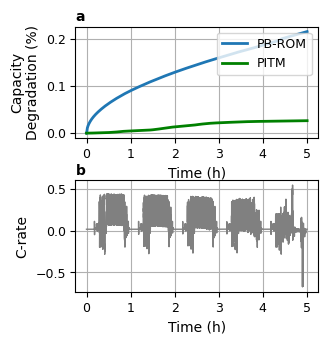

✅ Final plots generated and saved to PITM_Simulator_Final_Degradation.jpg


In [25]:
# In[8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import the pandas library, though not needed for smoothing

# -----------------------------------------------------------------
# --- 1. Prepare Data & Alignment (Referencing Cell 7 Constants) ---
# -----------------------------------------------------------------

# This calculates the baseline degradation from the physics model (PB-ROM).
# Uses CAP_NOM_NORM (which is 1.0) for division, fixing the scaling issue.
Q_total_sim = (np.array(Q_SEI_sim) + np.array(Q_AM_sim)) / Cap_Nom

# This is the final, integrated, and monotonic prediction (PITM).
Q_final_prediction = np.array(Q_exp_pred_sim)

# --- 2. Align all arrays to the shortest length (CRITICAL ALIGNMENT FIX) ---
L_sim = len(Ib_sim) 
L_pred = len(Q_final_prediction)
L_aligned = min(L_sim, L_pred)

# Build time vector: np.arange runs from 0 to L_aligned-1
t_hours = np.arange(L_aligned) * sim.Ts / 3600.0

# Align all arrays to the final, common length
Q_total_arr = Q_total_sim[:L_aligned]
Q_pred_arr  = Q_final_prediction[:L_aligned]
Crate_sim   = np.array(Ib_sim[:L_aligned]) / Cap_Nom # C-rate must use physical capacity (Cap_Ah_Phys)

# --- 3. Convert to Percentage ---
Q_total_pct = (Q_total_arr * 100)/1
Q_pred_pct = (Q_pred_arr * 100)/1 # This is the final, non-smoothed PITM prediction

# ----------------------------------------------------
# ⭐️ 4. REMOVAL OF SMOOTHING ⭐️
# The Moving Average calculation (Q_pred_ma_pct) is omitted here.
# ----------------------------------------------------

# --- 5. Create the Plot ---
axis_fs = 10
tick_fs = 9
legend_fs = 9

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 3.5), sharex=True)
fig.tight_layout(pad=2.0)

# --- Top: Capacity degradation ---
ax1.plot(t_hours, Q_total_pct, label='PB‑ROM', linewidth=2.0)
# 🛑 FIX: Plot the raw, non-smoothed Q_pred_pct array for the PITM result.
ax1.plot(t_hours, Q_pred_pct, label='PITM', linewidth=2.0, color='green') 

ax1.set_xlabel("Time (h)", fontsize=axis_fs)
ax1.set_ylabel("Capacity\nDegradation (%)", fontsize=axis_fs)
ax1.tick_params(axis='both', labelsize=tick_fs)
# Note: Adjusted legend location to be safer without hardcoded bbox
ax1.legend(fontsize=legend_fs, loc='upper right', frameon=True) 
ax1.grid(True)
ax1.tick_params(axis='x', labelbottom=True)
ax1.text(-0.0, 1.15, 'a', transform=ax1.transAxes, fontweight='bold', va='top')

# --- Bottom: C-rate (signed) ---
ax2.plot(t_hours, Crate_sim, color='gray', linewidth=1.0)
ax2.set_xlabel("Time (h)", fontsize=axis_fs)
ax2.set_ylabel("C‑rate", fontsize=axis_fs)
ax2.tick_params(axis='both', labelsize=tick_fs)
ax2.grid(True)
ax2.text(-0.0, 1.15, 'b', transform=ax2.transAxes, fontweight='bold', va='top')

plt.show()

# --- Save high-res JPEG ---
fig.savefig("PITM_Simulator_Final_Degradation.jpg", dpi=600, format='jpeg')
print("✅ Final plots generated and saved to PITM_Simulator_Final_Degradation.jpg")

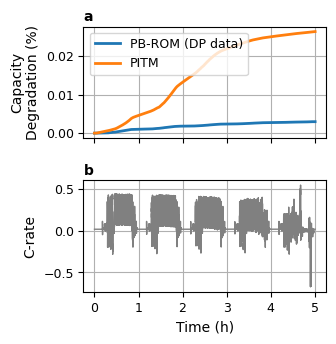

✅ Plot saved to PITM_Simulator_PBROM_vs_Data.jpg


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # not strictly needed, but fine

# -----------------------------------------------------------------
# 1. PBROM total degradation: sim vs data
# -----------------------------------------------------------------

# Single-cell nominal capacity (from earlier cells)
Cap_cell = Cap_Nom  # this is 1.0 in your case, but we keep the variable for clarity

# PBROM total from simulator (per cell)
Q_total_sim_raw = np.array(Q_SEI_sim) + np.array(Q_AM_sim)
Q_total_sim = Q_total_sim_raw / Cap_cell   # normalize if needed; here Cap_cell = 1

# PBROM total from DP data (per cell)
# q_sei and q_am were loaded in Cell 1 as:
#   q_sei = data['Q_SEI'].flatten()
#   q_am  = data['Q_AM'].flatten()
Q_total_data_raw = q_sei + q_am
Q_total_data = Q_total_data_raw / Cap_cell

# PITM prediction (already cumulative, on the same "per-cell normalized" scale)
Q_final_prediction = np.array(Q_exp_pred_sim)

# -----------------------------------------------------------------
# 2. Align lengths for fair comparison
# -----------------------------------------------------------------

L_sim   = len(Q_total_sim)
L_data  = len(Q_total_data)
L_pred  = len(Q_final_prediction)
L_align = min(L_sim, L_data, L_pred, len(Ib_sim))

# Time vector — use Time_s from DP data for alignment
t_hours = Time_s[:L_align] / 3600.0

Q_total_sim_aligned   = Q_total_sim[:L_align]
Q_total_data_aligned  = Q_total_data[:L_align]
Q_pred_aligned        = Q_final_prediction[:L_align]
Crate_sim             = np.array(Ib_sim[:L_align]) / Cap_cell  # per-cell C-rate

# -----------------------------------------------------------------
# 3. Convert to percentage (optional but nice for plotting)
# -----------------------------------------------------------------
Q_pbrom_sim_pct   = Q_total_sim_aligned * 100.0
Q_pbrom_data_pct  = Q_total_data_aligned * 100.0
Q_pitm_pct        = Q_pred_aligned * 100.0

# -----------------------------------------------------------------
# 4. Plot: PBROM (sim) vs PBROM (data) vs PITM + C-rate
# -----------------------------------------------------------------

axis_fs  = 10
tick_fs  = 9
legend_fs = 9

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 3.5), sharex=True)
fig.tight_layout(pad=2.0)

# --- Top: Capacity degradation ---
ax1.plot(t_hours, Q_pbrom_data_pct, label='PB-ROM (DP data)', linewidth=2.0)
# ax1.plot(t_hours, Q_pbrom_sim_pct,  label='PB-ROM (sim)',     linewidth=2.0, linestyle='--')
ax1.plot(t_hours, Q_pitm_pct,       label='PITM',             linewidth=2.0)

ax1.set_ylabel("Capacity\nDegradation (%)", fontsize=axis_fs)
ax1.tick_params(axis='both', labelsize=tick_fs)
ax1.legend(fontsize=legend_fs, loc='upper left', frameon=True)
ax1.grid(True)
ax1.text(-0.0, 1.15, 'a', transform=ax1.transAxes, fontweight='bold', va='top')

# --- Bottom: C-rate (signed), per cell ---
ax2.plot(t_hours, Crate_sim, color='gray', linewidth=1.0)
ax2.set_xlabel("Time (h)", fontsize=axis_fs)
ax2.set_ylabel("C-rate", fontsize=axis_fs)
ax2.tick_params(axis='both', labelsize=tick_fs)
ax2.grid(True)
ax2.text(-0.0, 1.15, 'b', transform=ax2.transAxes, fontweight='bold', va='top')

plt.show()

fig.savefig("PITM_Simulator_PBROM_vs_Data.jpg", dpi=600, format='jpeg')
print("✅ Plot saved to PITM_Simulator_PBROM_vs_Data.jpg")


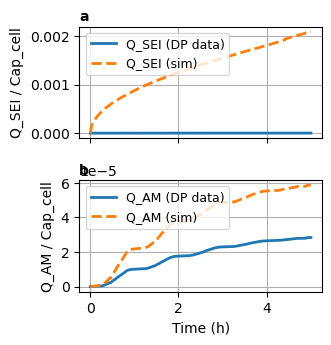

=== Final values at t_end (normalized by Cap_cell) ===
Q_SEI_data_norm_end : 1.337929e-06
Q_SEI_sim_norm_end  : 2.093093e-03
Ratio Q_SEI_sim/data : 1564.427
Q_AM_data_norm_end  : 2.840724e-05
Q_AM_sim_norm_end   : 5.872949e-05
Ratio Q_AM_sim/data  : 2.067


In [30]:
# ============================================================
# New Cell — Compare PB-ROM states: Q_SEI & Q_AM (sim vs data)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# Single-cell nominal capacity (for optional normalization)
Cap_cell = Cap_Nom  # should be 1.0 in your case, but keep general

# 1) Align lengths
L_sim  = min(len(Q_SEI_sim), len(Q_AM_sim), len(Ib_sim))
L_data = min(len(q_sei), len(q_am), len(Time_s))
L_algn = min(L_sim, L_data)

t_hours = Time_s[:L_algn] / 3600.0

Q_SEI_sim_arr = np.array(Q_SEI_sim[:L_algn])
Q_AM_sim_arr  = np.array(Q_AM_sim[:L_algn])

Q_SEI_data_arr = q_sei[:L_algn]
Q_AM_data_arr  = q_am[:L_algn]

# (optional) normalized versions per cell
Q_SEI_sim_norm  = Q_SEI_sim_arr  / Cap_cell
Q_AM_sim_norm   = Q_AM_sim_arr   / Cap_cell
Q_SEI_data_norm = Q_SEI_data_arr / Cap_cell
Q_AM_data_norm  = Q_AM_data_arr  / Cap_cell

# 2) Plot Q_SEI and Q_AM separately (normalized)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 3.5), sharex=True)
fig.tight_layout(pad=2.0)

# --- Q_SEI ---
ax1.plot(t_hours, Q_SEI_data_norm, label='Q_SEI (DP data)', linewidth=2.0)
ax1.plot(t_hours, Q_SEI_sim_norm,  label='Q_SEI (sim)',      linewidth=2.0, linestyle='--')
ax1.set_ylabel('Q_SEI / Cap_cell', fontsize=10)
ax1.legend(fontsize=9, loc='upper left', frameon=True)
ax1.grid(True)
ax1.text(-0.0, 1.15, 'a', transform=ax1.transAxes, fontweight='bold', va='top')

# --- Q_AM ---
ax2.plot(t_hours, Q_AM_data_norm, label='Q_AM (DP data)', linewidth=2.0)
ax2.plot(t_hours, Q_AM_sim_norm,  label='Q_AM (sim)',      linewidth=2.0, linestyle='--')
ax2.set_xlabel('Time (h)', fontsize=10)
ax2.set_ylabel('Q_AM / Cap_cell', fontsize=10)
ax2.legend(fontsize=9, loc='upper left', frameon=True)
ax2.grid(True)
ax2.text(-0.0, 1.15, 'b', transform=ax2.transAxes, fontweight='bold', va='top')

plt.show()

# 3) Print final values and ratios for debugging
print("=== Final values at t_end (normalized by Cap_cell) ===")
print(f"Q_SEI_data_norm_end : {Q_SEI_data_norm[-1]:.6e}")
print(f"Q_SEI_sim_norm_end  : {Q_SEI_sim_norm[-1]:.6e}")
print(f"Ratio Q_SEI_sim/data : {Q_SEI_sim_norm[-1] / Q_SEI_data_norm[-1]:.3f}")

print(f"Q_AM_data_norm_end  : {Q_AM_data_norm[-1]:.6e}")
print(f"Q_AM_sim_norm_end   : {Q_AM_sim_norm[-1]:.6e}")
print(f"Ratio Q_AM_sim/data  : {Q_AM_sim_norm[-1] / Q_AM_data_norm[-1]:.3f}")


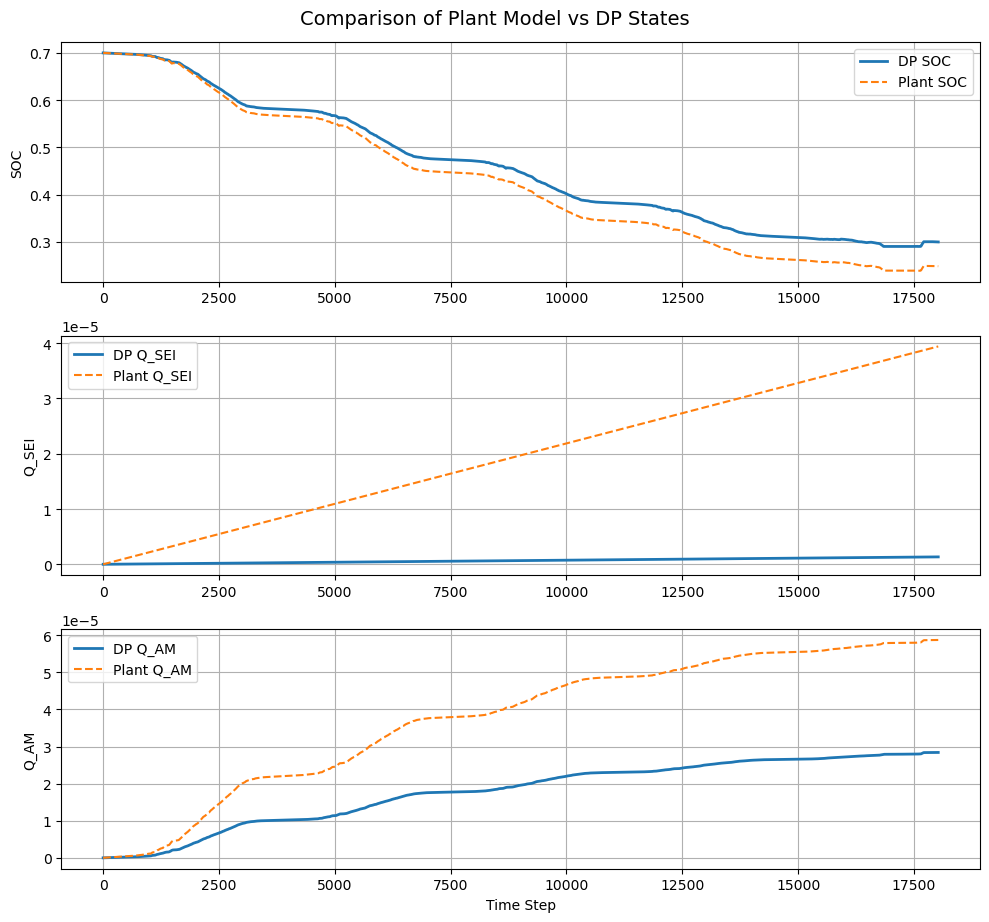

In [32]:
# Cell 4: Run Plant Model with DP Inputs and Compare with DP Results

# Instantiate simulator
sim = HEVSimulator('Range_Extender_Class_8_Parameters.mat', 'HHDDTdrivecycle_data.mat')

# Initial states
SOC_0 = 0.70
Q_SEI_0 = sim.Q_SEI_0
Q_AM_0 = 0.0

# Storage arrays
SOC_sim = [SOC_0]
Q_SEI_sim = [Q_SEI_0]
Q_AM_sim = [Q_AM_0]
m_dot_fuel_sim = []
dQ_SEI_sim = []
dQ_AM_sim = []
Ib_sim = []
v_sim = []
BAT_temp_sim = []

# Number of steps to simulate
N_steps = min(len(power_req), sim.N)

for t in range(N_steps):
    engine_power = dp_controls[t, 0]  # W
    engine_status = dp_controls[t, 1]  # 0 or 1
    gear_t = gear[t]
    power_req_t = power_req[t]

    soc_k = SOC_sim[-1]
    q_sei_k = Q_SEI_sim[-1]
    q_am_k = Q_AM_sim[-1]

    soc_next, dQ_SEI, dQ_AM, mfdot, Ib, v, BAT_temp = sim.evaluate_step(
        t, soc_k, q_sei_k, q_am_k, engine_power, engine_status, gear_t, power_req_t
    )

    # Accumulate and store
    SOC_sim.append(soc_next)
    dQ_SEI_sim.append(dQ_SEI)
    dQ_AM_sim.append(dQ_AM)
    m_dot_fuel_sim.append(mfdot)
    Ib_sim.append(Ib)
    v_sim.append(v)
    BAT_temp_sim.append(BAT_temp)

# Remove initial placeholder
SOC_sim = np.array(SOC_sim[1:])
Q_SEI_sim = Q_SEI_0 + np.cumsum(dQ_SEI_sim) * sim.Ts
Q_AM_sim  = Q_AM_0 + np.cumsum(dQ_AM_sim) * sim.Ts

dQ_SEI_sim = np.array(dQ_SEI_sim)
dQ_AM_sim = np.array(dQ_AM_sim)
m_dot_fuel_sim = np.array(m_dot_fuel_sim)

# Convert DP states for comparison
dp_SOC = dp_states[:N_steps, 0]
dp_Q_SEI = dp_states[:N_steps, 1]
dp_Q_AM = dp_states[:N_steps, 2]

# ── Plotting ──
plt.figure(figsize=(10, 9))

plt.subplot(3, 1, 1)
plt.plot(dp_SOC, label="DP SOC", linewidth=2)
plt.plot(SOC_sim, label="Plant SOC", linestyle='--')
plt.ylabel("SOC")
plt.grid(True); plt.legend()

plt.subplot(3, 1, 2)
plt.plot(dp_Q_SEI, label="DP Q_SEI", linewidth=2)
plt.plot(Q_SEI_sim, label="Plant Q_SEI", linestyle='--')
plt.ylabel("Q_SEI")
plt.grid(True); plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dp_Q_AM, label="DP Q_AM", linewidth=2)
plt.plot(Q_AM_sim, label="Plant Q_AM", linestyle='--')
plt.ylabel("Q_AM")
plt.xlabel("Time Step")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.suptitle("Comparison of Plant Model vs DP States", fontsize=14, y=1.02)
plt.show()
